# Project Workbook

Kiran John, Jason Suwito

## Overview

This workbook contains all of the code used to conduct our analysis on the milk quality dataset. We start with data processing and EDA, then move on to the code for each model. 

## Data Processing and EDA

### Imports

In [58]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# scikit learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# unsupervised learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


### Loading data

In [3]:
milkdata = pd.read_csv("milknew.csv")

In [4]:
milkdata.head()

pH  Temprature  Taste  Odor  Fat   Turbidity  Colour   Grade
0  6.6          35      1     0     1          0     254    high
1  6.6          36      0     1     0          1     253    high
2  8.5          70      1     1     1          1     246     low
3  9.5          34      1     1     0          1     255     low
4  6.6          37      0     0     0          0     255  medium

Look at value ranges

In [5]:
for column in milkdata.columns:
    print(f"Values in {column}:")
    print(milkdata[column].unique())
    print()

Values in pH:
[6.6 8.5 9.5 5.5 4.5 8.1 6.7 5.6 8.6 7.4 6.8 6.5 4.7 3.  9.  6.4]

Values in Temprature:
[35 36 70 34 37 45 60 66 50 55 90 38 40 43 42 41 65]

Values in Taste:
[1 0]

Values in Odor:
[0 1]

Values in Fat :
[1 0]

Values in Turbidity:
[0 1]

Values in Colour:
[254 253 246 255 250 247 245 240 248]

Values in Grade:
['high' 'low' 'medium']



Class distribution plot

In [6]:
color_scale = alt.Scale(domain=['low', 'medium', 'high'], 
                        range=['#002145', '#0055B7', '#00A7E1'])

class_chart = alt.Chart(milkdata).mark_bar().encode(
    x=alt.X('Grade', axis=alt.Axis(labelAngle=0, labelFontSize=14, labelFont='Arial'), title=None, sort='-y'),
    y=alt.Y('count()', title='Number of Records', axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial')),
    color=alt.Color('Grade', scale=color_scale, legend=None) 
).properties(
    width=600,
    height=400,
    title=alt.TitleParams(
        text='Distribution of Milk Grades',
        font='Arial',
        fontSize=18
    )
)

class_chart

alt.Chart(...)

Notice that the classes are uneven, with an emphasis on most milk being graded low, which can cause issues with our training. As we find out later, not balancing the classes does not seem to impact our model accuracies, so we choose to omit any additional processing here.

Quantitative feature distributions

In [7]:
# Temperature
temp_hist = alt.Chart(milkdata).mark_bar(color='#6EC4E8').encode(
    x=alt.X('Temprature:Q', bin=True, title='Temperature (°C)', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial'))
).properties(
    width=400,
    height=300,
    title=alt.TitleParams(
        text='Temperature Distribution',
        font='Arial',
        fontSize=18
    )
)

# pH
pH_hist = alt.Chart(milkdata).mark_bar(color='#6EC4E8').encode(
    x=alt.X('pH:Q', bin=True, title='pH', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial'))
).properties(
    width=400,
    height=300,
    title=alt.TitleParams(
        text='pH Distribution',
        font='Arial',
        fontSize=18
    )
)


# colour
colour_hist = alt.Chart(milkdata).mark_bar(color='#6EC4E8').encode(
    x=alt.X('Colour:Q', bin=True, title='Colour', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', labelFontSize=14, labelFont='Arial'))
).properties(
    width=400,
    height=300,
    title=alt.TitleParams(
        text='Colour Distribution',
        font='Arial',
        fontSize=18
    )
)

temp_hist | pH_hist | colour_hist

alt.HConcatChart(...)

It appears that there are some data points skewed towards higher temperatures, with most temperatures falling around 30 to 50 degrees. There are many more outliers in pH (on both ends), we may need to do some standardization here. However, most pH levels are between 6 and 7. Unlike temperature, colour appears to be more left skewed, but the vast majority of milk colours are between 254 and 256.

Qualitative feature distributions

In [8]:
# set dimensions to prevent overcrowding in display
chart_properties = {
    "width": 300,
    "height": 200
}


# Taste
taste_chart = alt.Chart(milkdata).mark_bar(color='#97D4E9').encode(
    x=alt.X('Taste:N', axis=alt.Axis(labelAngle=0, title='Taste', 
                                     labelFontSize=16, labelFont='Arial', titleFontSize=18, titleFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', 
                          labelFontSize=14, labelFont='Arial'))
).properties(**chart_properties)

# Odor
odor_chart = alt.Chart(milkdata).mark_bar(color='#97D4E9').encode(
    x=alt.X('Odor:N', axis=alt.Axis(labelAngle=0, title='Odor', 
                                    labelFontSize=16, labelFont='Arial', titleFontSize=18, titleFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', 
                          labelFontSize=14, labelFont='Arial'))
).properties(**chart_properties)

# Fat
fat_chart = alt.Chart(milkdata).mark_bar(color='#97D4E9').encode(
    x=alt.X('Fat :N', axis=alt.Axis(labelAngle=0, title='Fat', 
                                   labelFontSize=16, labelFont='Arial', titleFontSize=18, titleFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', 
                          labelFontSize=14, labelFont='Arial'))
).properties(**chart_properties)

# Turbidity
turbidity_chart = alt.Chart(milkdata).mark_bar(color='#97D4E9').encode(
    x=alt.X('Turbidity:N', axis=alt.Axis(labelAngle=0, title='Turbidity', 
                                         labelFontSize=16, labelFont='Arial', titleFontSize=18, titleFont='Arial')),
    y=alt.Y('count()', title='Count', 
            axis=alt.Axis(titleFontSize=16, titleFont='Arial', 
                          labelFontSize=14, labelFont='Arial'))
).properties(**chart_properties)

# Arrange the charts
(taste_chart | odor_chart) & (fat_chart | turbidity_chart)

alt.VConcatChart(...)

We can see a little bit of imbalance between some of the binary variables, mainly with fat in the milk.

Correlation matrix of features

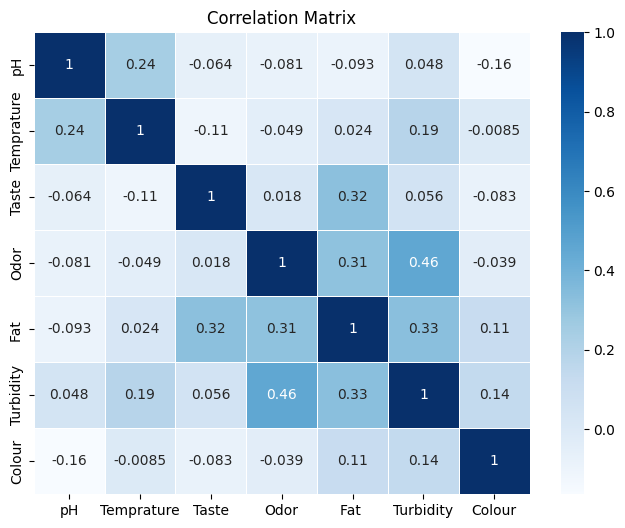

In [9]:
corr_matrix = milkdata.drop('Grade', axis = 1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Minor data cleaning

In [10]:
# removing extra space in 'Fat' column and correctly naming 'Temperature' column
milkdata.columns = milkdata.columns.str.strip()
milkdata.rename(columns = {'Temprature': 'Temperature'}, inplace = True)

# numerical encoding for target class so models can run
milkdata['Grade'] = milkdata['Grade'].map({'low': 0, 'medium': 1, 'high': 2})

X = milkdata.drop(columns = ['Grade'])
y = milkdata['Grade']

# standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 572) # set seed for reproducibility
y_train = np.array(y_train)

In [11]:
print(milkdata.count())

pH             1059
Temperature    1059
Taste          1059
Odor           1059
Fat            1059
Turbidity      1059
Colour         1059
Grade          1059
dtype: int64


In [12]:
print(milkdata.duplicated().sum())  # count duplicate rows

976


Create a separate dataset without duplicate values, this will help validate our models later

In [13]:
milkdata_nodup = milkdata.drop_duplicates()
X_nodup = milkdata_nodup.drop(columns=['Grade'])
y_nodup = milkdata_nodup['Grade']

# standardization
scaler = StandardScaler()
X_scaled_nodup = scaler.fit_transform(X_nodup)

# split the data into training and testing sets
X_train_nodup, X_test_nodup, y_train_nodup, y_test_nodup = train_test_split(X_scaled_nodup, y_nodup, test_size = 0.3, random_state = 572) # set seed for reproducibility
y_train_nodup = np.array(y_train_nodup)

## Logistic Regression

Model with default parameters

In [14]:
lr_default = LogisticRegression()

lr_default.fit(X_train, y_train)
y_pred = lr_default.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n") 
print(f"Parameters:\n {lr_default.get_params()}") # retrieve parameters to set grid ranges later


Accuracy: 0.8647798742138365 

Parameters:
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Full dataset model with tuning

Best Hyperparameters:  {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}

Best Model Accuracy: 0.8647798742138365

--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       131
           1       0.94      0.83      0.88       106
           2       0.76      0.88      0.81        81

    accuracy                           0.86       318
   macro avg       0.86      0.86      0.86       318
weighted avg       0.87      0.86      0.87       318

--------------------------------------------------


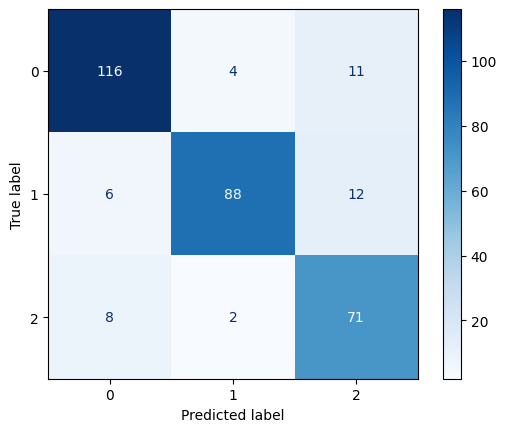

In [15]:
lr_model = LogisticRegression()

parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000, 2000, 3000, 5000],
}

grid_search = GridSearchCV(lr_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# predict using best model
lr_predictions = grid_search.best_estimator_.predict(X_test)

# best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# best model accuracy
best_lr_model_accuracy = grid_search.best_estimator_.score(X_test, y_test)
print(f"\nBest Model Accuracy: {best_lr_model_accuracy:}")


# classification report
print('\n--------------------------------------------------')
print("Classification Report:\n", classification_report(y_test, lr_predictions))
print('--------------------------------------------------')

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test, lr_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

No duplicate dataset model (using the best parameters from our full model)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.78      0.64      0.70        11
           2       0.40      0.80      0.53         5

    accuracy                           0.60        25
   macro avg       0.61      0.63      0.59        25
weighted avg       0.66      0.60      0.61        25

--------------------------------------------------

Model Accuracy: 0.6


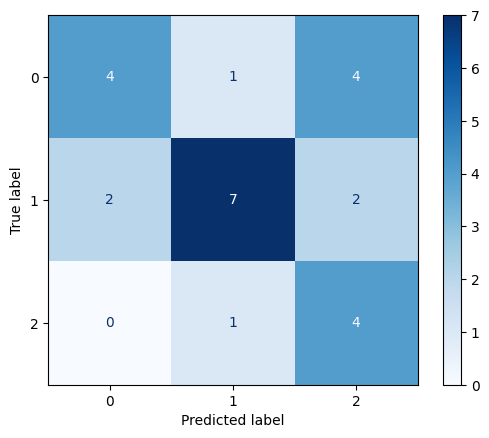

In [16]:
lr_model_nodup = LogisticRegression(
    C=1,
    max_iter=500,
    solver='lbfgs'
)

lr_model_nodup.fit(X_train_nodup, y_train_nodup)

# predictions
lr_predictions_nodup = lr_model_nodup.predict(X_test_nodup)

# classification report
print("Classification Report:\n", classification_report(y_test_nodup, lr_predictions_nodup))
print('--------------------------------------------------')

# model accuracy
lr_no_dupe_model_accuracy = lr_model_nodup.score(X_test_nodup, y_test_nodup)
print(f"\nModel Accuracy: {lr_no_dupe_model_accuracy}")  

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test_nodup, lr_predictions_nodup)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

## KNN

Model with default parameters. Note that our approach for knn is slightly different as grid search will return a value of k = 1 as the optimal value, which is not correct

In [17]:
knn_default = KNeighborsClassifier()

knn_default.fit(X_train, y_train)
y_pred = knn_default.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n") 

Accuracy: 0.9937106918238994 



Finding the ideal k-value before running our models

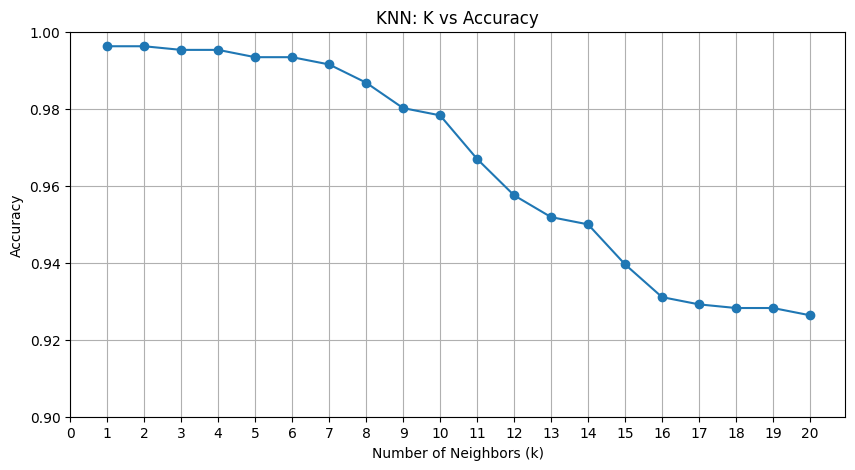

[0.9962264150943396,
 0.9962264150943396,
 0.9952830188679244,
 0.9952830188679244,
 0.9933872842707681,
 0.9933872842707681,
 0.991500491817938,
 0.9867700974693732,
 0.9801663238844676,
 0.9782795314316373,
 0.9669587767146561,
 0.9575114012340158,
 0.9518465528033623,
 0.949959760350532,
 0.9395734597156398,
 0.9310650093892516,
 0.9291782169364214,
 0.9282348207100062,
 0.9282348207100062,
 0.9263480282571761]

In [21]:
k_values = list(range(1, 21))
kf = KFold(n_splits=5, shuffle=True, random_state=572)
accuracies_sk = []

for k in k_values:
    knn = KNeighborsClassifier(k)
    scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='accuracy')
    accuracies_sk.append(np.mean(scores))

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies_sk, marker='o')
plt.ylim(0.9, 1)
plt.xticks(range(0, 21, 1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN: K vs Accuracy")
plt.grid(True)
plt.show()

accuracies_sk

The issue we face here is that it seems that k = 1 is ideal, but we know that choosing this value will make the model extremely prone to overfitting.

Let's instead leverage our no duplicate dataset to find a better value.

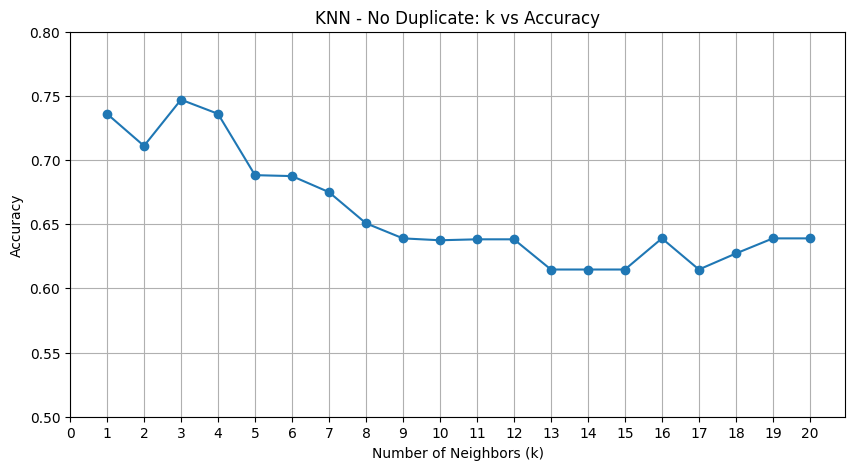

(3, 0.7470588235294118)

In [22]:
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled_nodup, y_nodup, cv=kf, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

    knn = KNeighborsClassifier(k)
    knn.fit(X_train_nodup, y_train_nodup)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies_sk.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o')
plt.ylim(0.5, 0.8)
plt.xticks(range(0, 21, 1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN - No Duplicate: k vs Accuracy")
plt.grid(True)
plt.show()

optimal_k = k_values[np.argmax(accuracy_scores)]
optimal_k, max(accuracy_scores)

We find that k = 3 seems to be the best value, let's apply the model on the full dataset now

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       131
           1       1.00      1.00      1.00       106
           2       0.98      1.00      0.99        81

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318

--------------------------------------------------

Model Accuracy: 0.9937106918238994


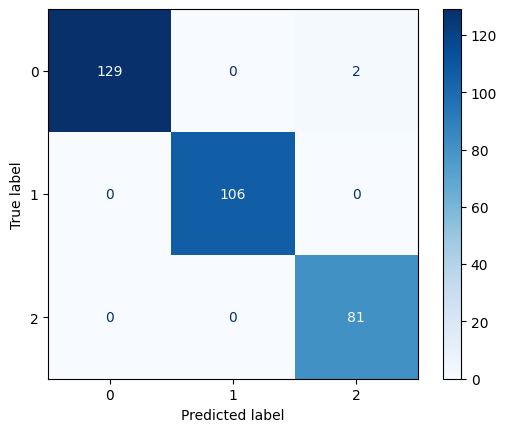

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# classification report
print("Classification Report:\n", classification_report(y_test, knn_predictions))
print('--------------------------------------------------')

# Best model accuracy
best_knn_model_accuracy = knn_model.score(X_test, y_test)
print(f"\nModel Accuracy: {best_knn_model_accuracy:}")

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test, knn_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

Finally, apply the model with k = 3 on the no duplicate dataset

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.82      0.82      0.82        11
           2       0.36      0.80      0.50         5

    accuracy                           0.60        25
   macro avg       0.62      0.61      0.55        25
weighted avg       0.67      0.60      0.58        25

--------------------------------------------------

Model Accuracy: 0.6


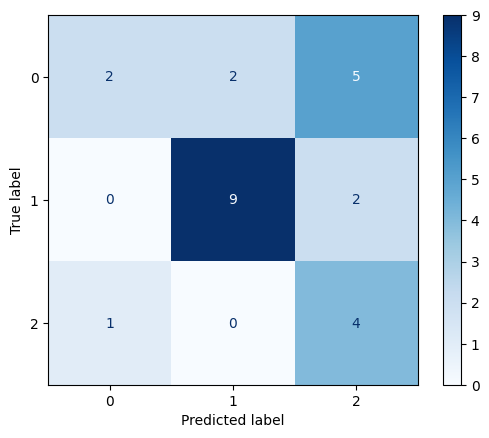

In [24]:
knn_model_nodup = KNeighborsClassifier(n_neighbors=3)

knn_model_nodup.fit(X_train_nodup, y_train_nodup)

# predictions
knn_predictions_nodup = knn_model_nodup.predict(X_test_nodup)

# classification report
print("Classification Report:\n", classification_report(y_test_nodup, knn_predictions_nodup))
print('--------------------------------------------------')

# model accuracy
knn_no_dupe_model_accuracy = knn_model_nodup.score(X_test_nodup, y_test_nodup)
print(f"\nModel Accuracy: {knn_no_dupe_model_accuracy}")  

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test_nodup, knn_predictions_nodup)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

## Decision Tree

Model with default parameters

In [25]:
dt_default = DecisionTreeClassifier(random_state=572)

dt_default.fit(X_train, y_train)
y_pred = dt_default.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n") 
print(f"Parameters:\n {dt_default.get_params()}") # retrieve parameters to set grid ranges later

Accuracy: 0.9905660377358491 

Parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 572, 'splitter': 'best'}


Full dataset model with tuning

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       131
           1       1.00      1.00      1.00       106
           2       0.98      0.99      0.98        81

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318

--------------------------------------------------

Best Model Accuracy: 0.9905660377358491


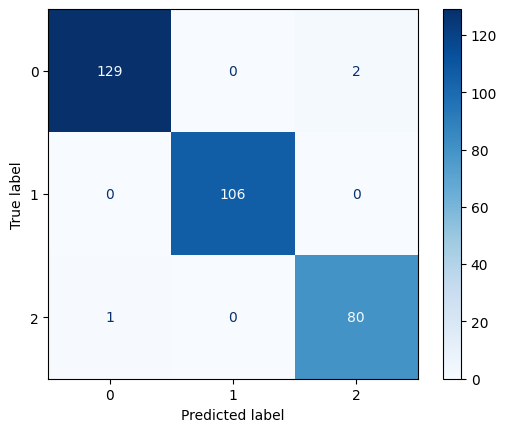

In [26]:
dt_model = DecisionTreeClassifier(random_state=572)

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(dt_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# predictions
dt_predictions = grid_search.best_estimator_.predict(X_test)

# best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)
print('--------------------------------------------------')

# classification report
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print('--------------------------------------------------')

# Best model accuracy
dt_best_model_accuracy = grid_search.best_estimator_.score(X_test, y_test)
print(f"\nBest Model Accuracy: {dt_best_model_accuracy:}")

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test, dt_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

No duplicate dataset model (using the best parameters from our full model)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       1.00      0.55      0.71        11
           2       0.50      1.00      0.67         5

    accuracy                           0.68        25
   macro avg       0.72      0.74      0.68        25
weighted avg       0.78      0.68      0.68        25

--------------------------------------------------

Best Model Accuracy: 0.68


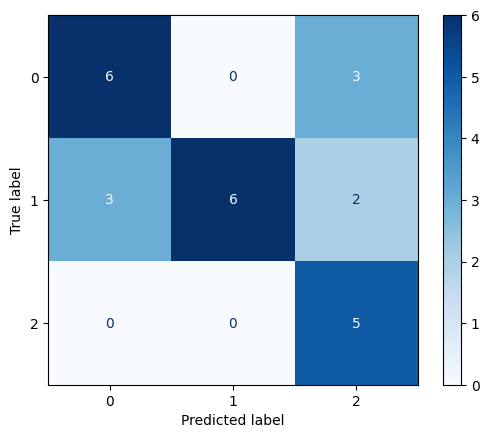

In [27]:
dt_model_nodup = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2
)

dt_model_nodup.fit(X_train_nodup, y_train_nodup)

# predictions
dt_predictions_nodup = dt_model_nodup.predict(X_test_nodup)

# classification report
print("Classification Report:\n", classification_report(y_test_nodup, dt_predictions_nodup))
print('--------------------------------------------------')

# model accuracy
dt_no_dupe_model_accuracy = dt_model_nodup.score(X_test_nodup, y_test_nodup)
print(f"\nBest Model Accuracy: {dt_no_dupe_model_accuracy}")  

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test_nodup, dt_predictions_nodup)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

## Random Forest

Model with default parameters

In [177]:
random_forest = RandomForestClassifier(random_state=572)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n") 
print(f"Classification Report for Random Forest Model: ") 
print(random_forest.get_params())

Accuracy: 0.9905660377358491 

Classification Report for Random Forest Model: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 572, 'verbose': 0, 'warm_start': False}


Full dataset model with tuning

Best Hyperparameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       131
           1       0.99      1.00      1.00       106
           2       0.98      0.99      0.98        81

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318

--------------------------------------------------

Best Model Accuracy: 0.9905660377358491


c:\Users\kirki\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


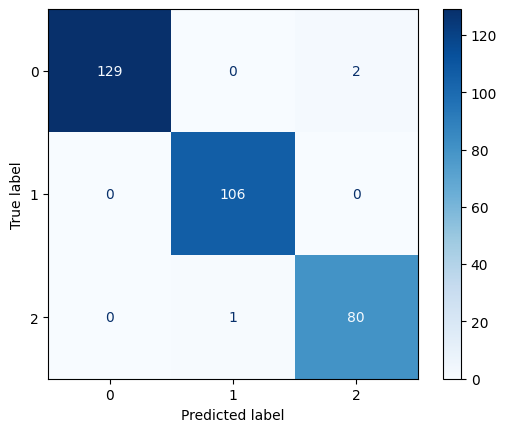

In [183]:
rf_model = RandomForestClassifier(random_state=572)

parameters = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(rf_model, parameters, cv=5)
grid_search.fit(X_train, y_train)

# predictions
rf_predictions = grid_search.best_estimator_.predict(X_test)

# best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)
print('--------------------------------------------------')

# classification report
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print('--------------------------------------------------')

# Best model accuracy
rf_best_model_accuracy = grid_search.best_estimator_.score(X_test, y_test)
print(f"\nBest Model Accuracy: {rf_best_model_accuracy:}")

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test, rf_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

No duplicate dataset model (using the best parameters from our full model)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.90      0.82      0.86        11
           2       0.36      0.80      0.50         5

    accuracy                           0.68        25
   macro avg       0.75      0.69      0.66        25
weighted avg       0.83      0.68      0.70        25

--------------------------------------------------

Best Model Accuracy: 0.68


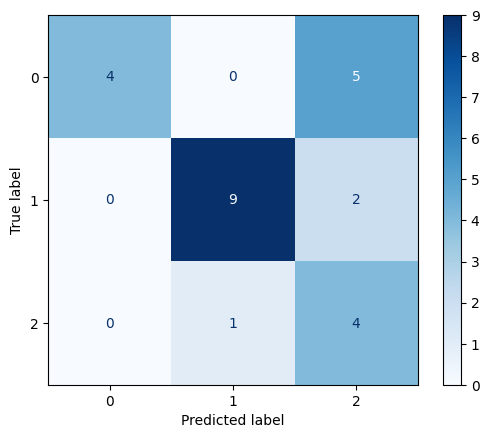

In [186]:
rf_model_nodup = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=50
)

rf_model_nodup.fit(X_train_nodup, y_train_nodup)

# predictions
rf_predictions_nodup = rf_model_nodup.predict(X_test_nodup)

# classification report
print("Classification Report:\n", classification_report(y_test_nodup, rf_predictions_nodup))
print('--------------------------------------------------')

# model accuracy
rf_no_dupe_model_accuracy = rf_model_nodup.score(X_test_nodup, y_test_nodup)
print(f"\nBest Model Accuracy: {rf_no_dupe_model_accuracy}")  

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test_nodup, rf_predictions_nodup)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

## MLP (Multilayer Perceptron)

Once again our approach is slightly different as we can use keras tuner (instead of grid search) to optimize our parameters. Let's start with a 'base' model on the full dataset

Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4961 - loss: 1.0420 - val_accuracy: 0.7138 - val_loss: 0.7703
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.7840 - val_accuracy: 0.8050 - val_loss: 0.5717
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7619 - loss: 0.5962 - val_accuracy: 0.9025 - val_loss: 0.4420
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.5231 - val_accuracy: 0.9151 - val_loss: 0.3622
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.4042 - val_accuracy: 0.9465 - val_loss: 0.2936
Epoch 6/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8730 - loss: 0.3470 - val_accuracy: 0.9403 - val_loss: 0.2496
Epoch 7/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8894 - loss: 0.3048 - val_accuracy: 0.9465 - val_loss: 0.2253
Epoch 8/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9136 - loss: 0.2543 - val_accuracy: 0.

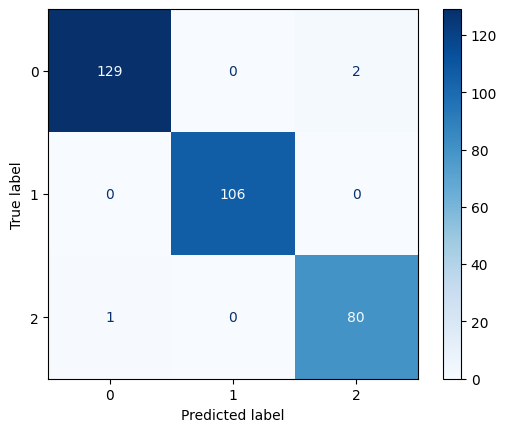

In [ ]:
# each Dense() call is a dense layer added to the model
# Dropout() sets a subset of the neurons to 0, which prevent overfitting
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(64, activation='relu'), # accounts for non-linearity
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# compile model
model.compile(
    optimizer='adam', # most commonly used optimizer, we will leave this
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# set an early stop to find the 'best' number of epochs
# here we check to see if there's any decrease in validation
early_stopping = EarlyStopping(
    monitor='loss',             # using loss instead of validation loss since the dataset is not very large
    patience=10,                # low patience to prevent overfitting
    restore_best_weights=True   # uses the best performing model instead of previous model in training
)

# train model with early stopping
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=1000, 
    batch_size=16,
    callbacks=[early_stopping] 
)

test_loss, mlp_model_accuracy = model.evaluate(X_test, y_test)
print(f"\nModel Accuracy: {mlp_model_accuracy}")

# predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# classification report
print('--------------------------------------------------')
print("Classification Report:\n", classification_report(y_test, y_pred_classes))
print('--------------------------------------------------')

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')

# show plot
plt.show()


No duplicate dataset

In [ ]:

y_pred = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test_nodup, y_test_nodup)

# confusion matrix
grades = ['0', '1', '2']
cm = confusion_matrix(y_test_nodup, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=grades)
disp.plot(cmap='Blues')